# VII Robust model fitting

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def homogeneous(p):
    try:
        _, n = p.shape
    except:
        p.reshape(2, 1)
        n = 1
    return np.vstack((p, np.ones(n)))

## RANSAC

In [5]:
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

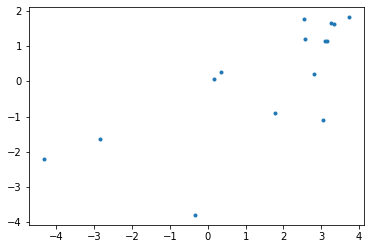

In [3]:
points = test_points(n_in=10, n_out=5)
plt.plot(points[0], points[1], '.');

### 1. Line estimation

In [225]:
def get_line_parameters(points):
    points = homogeneous(points)
    a, b, c = np.cross(points[:, 0], points[:, 1])
    return np.array([a, b, c]) / np.linalg.norm([a, b])

In [226]:
p = np.array([8, 2]).reshape(2, 1)
q = np.array([-8, -3]).reshape(2, 1)
points = np.hstack((p, q))
print(points[:, 0])

a, b, c = get_line_parameters(points)

a * p[0] + b * p[1] + c

[8 2]


array([1.11022302e-16])

### 2. Inliers

In [234]:
def is_inlier(p, line, threshold):
    p = homogeneous(p)
    line = np.array(line)
    distance_to_line = np.linalg.norm(
        line.reshape((1, 3)) @ p.reshape((3, 1))
    )
    return distance_to_line < threshold

In [235]:
is_inlier(p, [a, b, c], 0.01)

True

### 3. Consensus

In [262]:
def consensus(points, line, threshold):
    _, n = points.shape
    inlier = [is_inlier(points[:, i].reshape(2, 1), line, threshold) for i in range(n)]
    return np.sum(inlier)

In [263]:
consensus(np.hstack((p, q)), [a, b, c], 1)

2

### 4. Random draw

In [280]:
def draw_two(points):
    _, n = points.shape
    i, j = np.random.randint(n, size=2)
    if i != j:
        return points[:, [i, j]]
    else:
        return draw_two(points)

In [281]:
draw_two(np.hstack((p, q)))

array([[-8,  8],
       [-3,  2]])

### 5-8. Full RANSAC algorithm

In [341]:
def RANSAC(points, tau, p=0.99, recompute_line=True):
    M = points.shape[1]
    m = 0
    s = 0
    N = 1
    eps = 0

    while m < N:
        two_points = draw_two(points)
        line = get_line_parameters(two_points)
        n_in = consensus(points, line, tau)

        if n_in > s:
            s = n_in
            best_guess = two_points

        m += 1
        eps = 1 - s / M
        N = np.log(1 - p) / np.log(1 - (1 - eps) ** 2)
    
    line = get_line_parameters(best_guess)
    if recompute_line:
        inlier_mask = [is_inlier(points[:, i].reshape(2, 1), line, tau) for i in range(M)]
        line = pca_line(points[:, inlier_mask])
        
    return line


def get_y(x, line):
    a, b, c = line
    return - (x * a + c) / b

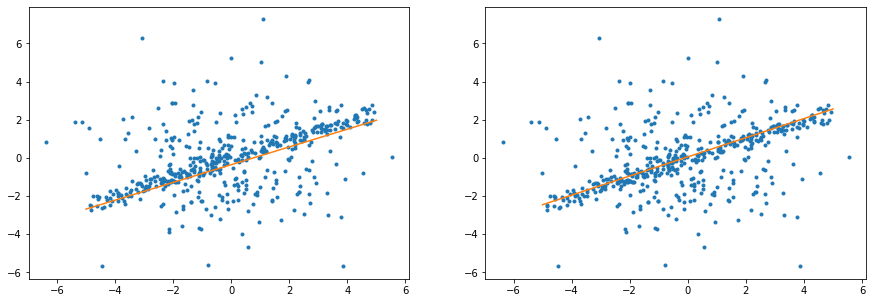

In [343]:
points = test_points(n_in=250, n_out=250)
line1 = RANSAC(points, tau=1, p = 0.99, recompute_line=False)
line2 = RANSAC(points, tau=1, p = 1-1e-10)

x = np.array([-5, 5])
y1 = get_y(x, line1)
y2 = get_y(x, line2)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(points[0], points[1], '.');
ax[0].plot(x, y1);

ax[1].plot(points[0], points[1], '.');
ax[1].plot(x, y2);

- comments
- functions documentation